# Covolutional Neural Network

We will explore Covnet structure in this notebook. Using tensorboard as a means to log metrics for training and valiidation.

784 - **[32C5-32C5S2-64C5-64C5S2]** - 128 - 10: is the structure which is best from this exploration with drop out and batch normalisation.

In [2]:
import os
import sys
from pathlib import Path
sys.path.append("../")
from dotenv import find_dotenv, load_dotenv
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import random_split
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)
logger.info("Setting up logging...")


from src.utils import CustomMnistDataset, imshow, train_covnet

load_dotenv(find_dotenv())

DATA_DIR= os.getenv('DATA_DIR')
SEED = int(os.getenv('SEED')) #type: ignore
TENSORBOARD_DIR = Path(os.getenv('TENSORBOARD_DIR'))
MODEL_DIR = Path(os.getenv('MODEL_DIR'))
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
augmentor = nn.Sequential(
    T.RandomAffine(degrees = 10, translate = (0.1, 0.1), scale = (0.9, 1.1))
)
dataset = CustomMnistDataset(img_dir = DATA_DIR, train=True, transform=augmentor)
train_dataset, val_dataset = random_split(
    dataset,
    [0.75, 0.25],
    generator=torch.Generator().manual_seed(SEED)
    )


In [4]:
BATCH_SIZE = 20
SHUFFLE = True
EPOCHS = 50
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
optimizer_wrapper = lambda x: optim.SGD(x, lr=0.01, momentum=0.9)

## 784 - **[32C5-P2S2]** - 128 - 10

In [5]:
exp_name='32C5-P2S2-128-10'
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # (32, 24, 24)
        self.pool = nn.MaxPool2d(2, 2) # (32, 12, 12)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
train_dict = train_covnet(
    net = Net(),
    dataloader = train_dataloader,
    epochs = EPOCHS,
    optimizer_wrapper = optimizer_wrapper,
    criterion = nn.CrossEntropyLoss(),
    writer = SummaryWriter(Path(TENSORBOARD_DIR, exp_name)), #type; ignore
    val_dataloader = val_dataloader
)
torch.save(train_dict.get('model').state_dict(), Path(MODEL_DIR, exp_name))

### Plotting examples

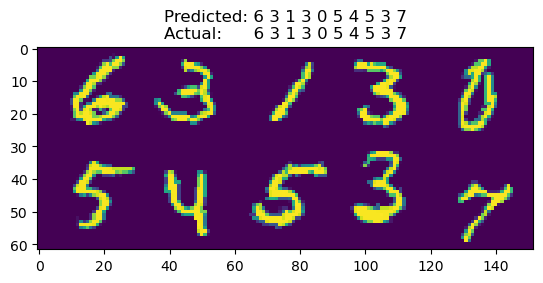

In [6]:
inputs, classes = next(iter(train_dataloader))
model = Net()
model.load_state_dict(torch.load(Path(MODEL_DIR, exp_name)))
model.eval()
inputs = inputs[:10]
classes = classes[:10]
outputs = model(inputs) #type: ignore
_, predicted = torch.max(outputs, 1)
out = make_grid(inputs, nrow=5)
title = 'Predicted: '+' '.join(f'{j}' for j in predicted)+'\nActual:      '+\
    ' '.join((f'{j}' for j in classes))
imshow(out, title = title)

## 784 - **[32C5-P2S2-64C5-P2S2]** - 128 - 10

In [7]:
exp_name='32C5-P2S2-64C5-P2S2-128-10'
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 12, 12)
        x = self.pool((F.relu(self.conv2(x)))) #(64, 4, 4)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
train_dict = train_covnet(
    net = Net(),
    dataloader = train_dataloader,
    epochs = EPOCHS,
    optimizer_wrapper = optimizer_wrapper,
    criterion = nn.CrossEntropyLoss(),
    writer = SummaryWriter(Path(TENSORBOARD_DIR, exp_name)), #type; ignore
    val_dataloader = val_dataloader
)
torch.save(train_dict.get('model').state_dict(), Path(MODEL_DIR, exp_name) )

### Plotting examples

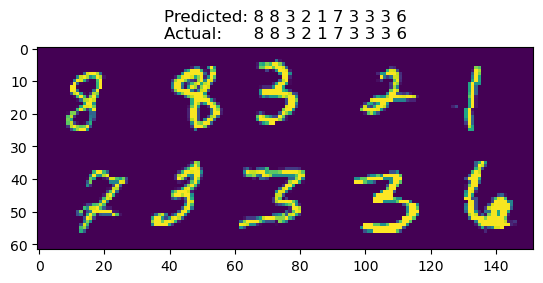

In [8]:
inputs, classes = next(iter(train_dataloader))
model = Net()
model.load_state_dict(torch.load(Path(MODEL_DIR, exp_name)))
model.eval()
inputs = inputs[:10]
classes = classes[:10]
outputs = model(inputs) #type: ignore
_, predicted = torch.max(outputs, 1)
out = make_grid(inputs, nrow=5)
title = 'Predicted: '+' '.join(f'{j}' for j in predicted)+'\nActual:      '+\
    ' '.join((f'{j}' for j in classes))
imshow(out, title = title)

## 784 - **[32C5-P2S2-64C5-P2S2]** - 128 - 10 with Batch normaliization and Dropout.

In [9]:
exp_name='32C5-P2S2-64C5-P2S2-128-10-BN-DO'
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.bn1(self.conv1(x))))) # (32, 12, 12)
        x = self.dropout(self.pool(F.relu(self.bn2((self.conv2(x))))))#(64, 4, 4)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x
    
train_dict = train_covnet(
    net = Net(),
    dataloader = train_dataloader,
    epochs = EPOCHS,
    optimizer_wrapper = optimizer_wrapper,
    criterion = nn.CrossEntropyLoss(),
    writer = SummaryWriter(Path(TENSORBOARD_DIR, exp_name)), #type; ignore
    val_dataloader = val_dataloader
)
torch.save(train_dict.get('model').state_dict(), Path(MODEL_DIR, exp_name) )

### Plotting examples

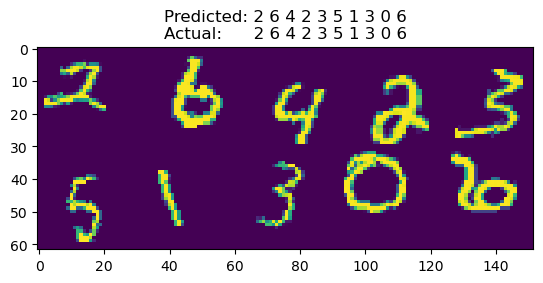

In [ ]:
inputs, classes = next(iter(train_dataloader))
model = Net()
model.load_state_dict(torch.load(Path(MODEL_DIR, exp_name)))
model.eval()
outputs = model(inputs) #type: ignore
_, predicted = torch.max(outputs, 1)
out = make_grid(inputs, nrow=5)
title = 'Predicted: '+' '.join(f'{j}' for j in predicted)+'\nActual:      '+\
    ' '.join((f'{j}' for j in classes))
imshow(out, title = title)

## 784 - **[32C5-32C5S2-64C5-64C5S2]** - 128 - 10 with Batch normalization and Dropout. 

This mimics the Max pooling layer using a trainable convlutional layer.

In [12]:
exp_name='32C5-32C5S2-64C5-64C5S2-128-10'
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # 32, 24, 24, 
        self.pool1 = nn.Conv2d(32, 32, 5, 2, padding=2) 
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.pool2 = nn.Conv2d(64, 64, 5, 2, padding=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.4)


    def forward(self, x):
        x = self.dropout(self.pool1(F.relu(self.bn1(self.conv1(x))))) # (32, 12, 12)
        x = self.dropout(self.pool2(F.relu(self.bn2((self.conv2(x)))))) #(64, 4, 4)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x
  
train_dict = train_covnet(
    net = Net(),
    dataloader = train_dataloader,
    epochs = EPOCHS,
    optimizer_wrapper = optimizer_wrapper,
    criterion = nn.CrossEntropyLoss(),
    writer = SummaryWriter(Path(TENSORBOARD_DIR, exp_name)), #type; ignore
    val_dataloader = val_dataloader
)
torch.save(train_dict.get('model').state_dict(), Path(MODEL_DIR, exp_name) )

### Plotting examples

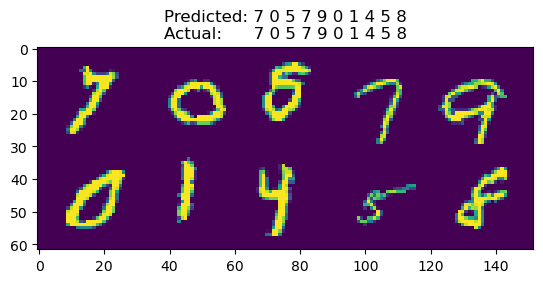

In [13]:
inputs, classes = next(iter(train_dataloader))
model = Net()
model.load_state_dict(torch.load(Path(MODEL_DIR, exp_name)))
model.eval()
inputs = inputs[:10]
classes = classes[:10]
outputs = model(inputs) #type: ignore
_, predicted = torch.max(outputs, 1)
out = make_grid(inputs, nrow=5)
title = 'Predicted: '+' '.join(f'{j}' for j in predicted)+'\nActual:      '+\
    ' '.join((f'{j}' for j in classes))
imshow(out, title = title)